Parâmetros:
  carga q = 1.800e-06 C, posição [0. 0. 0.]
  centro do quadrado = [0.  0.  0.3], normal (unit) = [0. 0. 1.], lado L = 0.0032 m

Resultados:
  Fluxo elétrico (numérico, soma discreta) = 1.871662e+00 V·m
  Aproximação (E no centro * área) = 1.840651e+00 V·m

Observação: se o quadrado envolver a carga (enclose), o fluxo total pela superfície fechada obedeceria a q/epsilon0; aqui calculamos só através de UMA face (aberta).


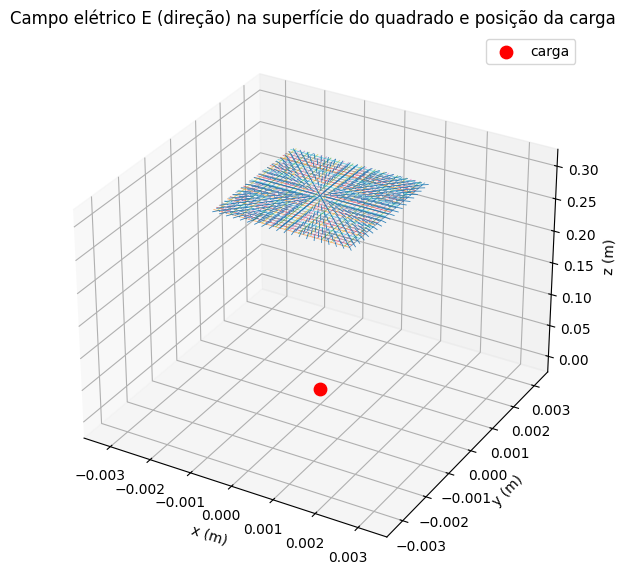

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ----------------------------
# Parâmetros físicos e malha
# ----------------------------
epsilon0 = 8.854187817e-12        # permitividade do vácuo (F/m)
k_const = 1.0 / (4 * np.pi * epsilon0)  # 1/(4*pi*epsilon0)

# Carga pontual (SI)
q = 1.8e-6               # carga em coulombs (ex.: 1.8 µC)
charge_pos = np.array([0.0, 0.0, 0.0])  # posição da carga (origem)

# Definição do quadrado (centro, normal e lado)
square_center = np.array([0.0, 0.0, 0.3])   # centro do quadrado (m)
square_normal = np.array([0.0, 0.0, 1.0])   # vetor normal (não precisa ser unitário)
L = 0.0032               # lado do quadrado em metros (3.2 mm -> 0.0032 m)

# Resolução da malha na superfície do quadrado (N x N pontos)
N = 120  # quanto maior, mais preciso (mais caro computacionalmente)

# ----------------------------
# Construir sistema de coordenadas na superfície
# ----------------------------
n = square_normal / np.linalg.norm(square_normal)   # normal unitário

# Escolher um vetor auxiliar para construir base u,v no plano do quadrado
# pick any vector not parallel to n:
if abs(n[0]) < 0.9:
    aux = np.array([1.0, 0.0, 0.0])
else:
    aux = np.array([0.0, 1.0, 0.0])

u = np.cross(n, aux)
u = u / np.linalg.norm(u)
v = np.cross(n, u)
v = v / np.linalg.norm(v)

# Coordenadas locais (s,t) que percorrem o quadrado
s = np.linspace(-L/2, L/2, N)
t = np.linspace(-L/2, L/2, N)
S, T = np.meshgrid(s, t)

# Matrizes de pontos 3D na superfície
points = square_center.reshape(1,1,3) + S[:,:,None]*u.reshape(1,1,3) + T[:,:,None]*v.reshape(1,1,3)
# points tem shape (N, N, 3)

# ----------------------------
# Calcular campo elétrico em cada ponto da superfície
# ----------------------------
# vetor r de cada ponto para a carga: r = point - charge_pos
r = points - charge_pos.reshape(1,1,3)   # shape (N,N,3)
r_norm = np.linalg.norm(r, axis=2)       # shape (N,N)
# evitar divisão por zero caso a carga esteja exatamente sobre a superfície
r_norm_safe = np.where(r_norm == 0, np.finfo(float).eps, r_norm)

# campo E: k * q * r_hat / r^2 = k * q * r / r^3
E = k_const * q * (r / (r_norm_safe[:,:,None]**3))   # shape (N,N,3)

# ----------------------------
# Integral do fluxo: soma discreta de E·n * dA
# ----------------------------
dA = (L / (N-1))**2   # área de cada elemento (aprox). note: (N-1) para espaçamento entre pontos
# produto escalar E·n em cada ponto
E_dot_n = np.sum(E * n.reshape(1,1,3), axis=2)  # shape (N,N)

# fluxo numérico
flux_numeric = np.sum(E_dot_n) * dA

# Para referência: aproximação usando E no centro vezes a área
center_E = k_const * q * ((square_center - charge_pos) / np.linalg.norm(square_center - charge_pos)**3)
flux_center_approx = np.dot(center_E, n) * (L**2)

# ----------------------------
# Exibir resultados
# ----------------------------
print("Parâmetros:")
print(f"  carga q = {q:.3e} C, posição {charge_pos}")
print(f"  centro do quadrado = {square_center}, normal (unit) = {n}, lado L = {L} m")
print()
print("Resultados:")
print(f"  Fluxo elétrico (numérico, soma discreta) = {flux_numeric:.6e} V·m")
print(f"  Aproximação (E no centro * área) = {flux_center_approx:.6e} V·m")
print()
print("Observação: se o quadrado envolver a carga (enclose), o fluxo total pela superfície fechada obedeceria a q/epsilon0; aqui calculamos só através de UMA face (aberta).")

# ----------------------------
# Visualização 3D (campo e superfície)
# ----------------------------
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

# plotar carga
ax.scatter([charge_pos[0]], [charge_pos[1]], [charge_pos[2]], color='red', s=80, label='carga')

# plotar malha da superfície como linhas
# linhas horizontais e verticais do quadrado
for i in range(0, N, max(1, N//25)):
    ax.plot(points[i,:,0], points[i,:,1], points[i,:,2], linewidth=0.6, alpha=0.6)
    ax.plot(points[:,i,0], points[:,i,1], points[:,i,2], linewidth=0.6, alpha=0.6)

# Para visualizar o campo, plotar vetores E reduzidos (quiver) em uma sub-amostra
step = max(1, N//20)
X = points[::step, ::step, 0]
Y = points[::step, ::step, 1]
Z = points[::step, ::step, 2]
Ex = E[::step, ::step, 0]
Ey = E[::step, ::step, 1]
Ez = E[::step, ::step, 2]

# normalizar vetores para melhor visualização dos direcionamentos
mag = np.sqrt(Ex**2 + Ey**2 + Ez**2)
mag_safe = np.where(mag == 0, 1.0, mag)
Exn, Eyn, Ezn = Ex/mag_safe, Ey/mag_safe, Ez/mag_safe

ax.quiver(X, Y, Z, Exn, Eyn, Ezn, length=L*0.6, normalize=False, linewidth=0.6, pivot='middle', alpha=0.9)

# decorações
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.set_title('Campo elétrico E (direção) na superfície do quadrado e posição da carga')
ax.legend()
ax.auto_scale_xyz([-L, L, -L], [-L, L, -L], [min(charge_pos[2], square_center[2])-L, max(charge_pos[2], square_center[2])+L])
plt.show()


--- Simulação de Fluxo Elétrico ---
Lado do Quadrado (L): 2.0 m
Distância da Carga (z): 1.0 m
Resolução da Grade: 100x100 (10000 elementos)
-----------------------------------
Fluxo Elétrico Simulado (Numérico): 18829.07334 N·m²/C
Fluxo Elétrico Teórico (Lei de Gauss): 18828.61197 N·m²/C
Diferença (Erro): 0.0025 %


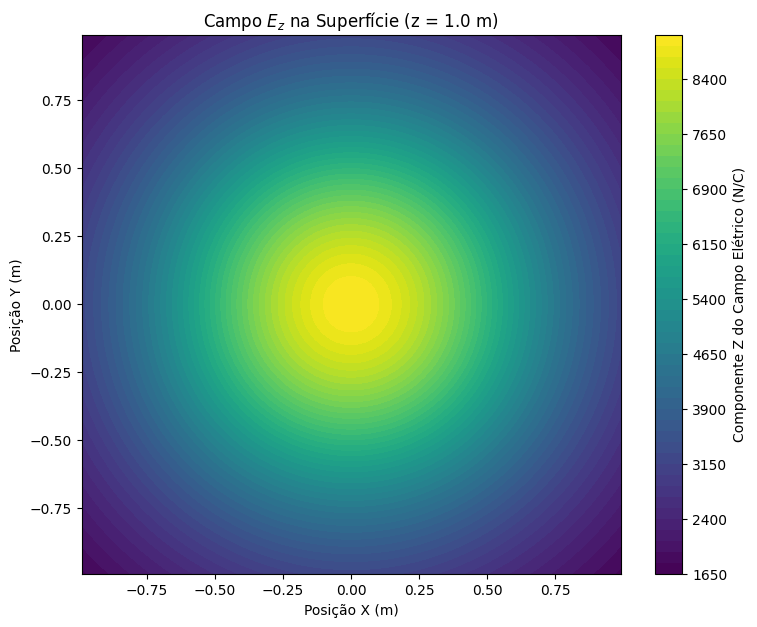

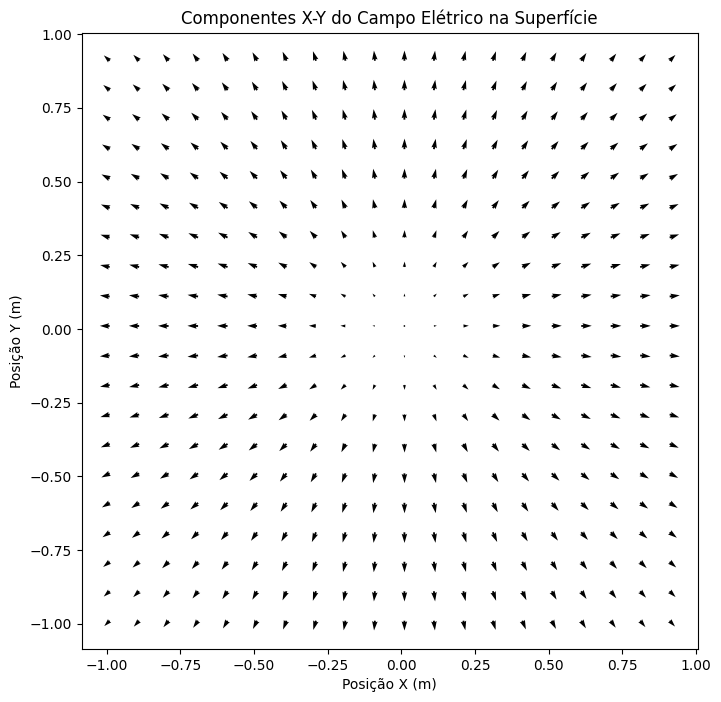

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Constantes e Configuração ---
# Explicando:
# k: Constante de Coulomb (N·m²/C²)
# q: Carga da partícula (1.0 micro-Coulomb)
# epsilon_0: Permissividade do vácuo, calculada a partir de k
k = 8.99e9
q = 1.0e-6  # 1.0 µC
epsilon_0 = 1 / (4 * np.pi * k)

# --- 2. Parâmetros da Simulação (Superfície) ---
# Explicando:
# Vamos recriar o cenário do problema 4: um quadrado de aresta L
# posicionado a uma distância z = L/2 da carga (que está na origem).
# N: Resolução da grade (N x N). 100x100 = 10.000 pedaços.
L_aresta = 2.0  # Lado do quadrado (em metros)
dist_z = L_aresta / 2.0  # Distância da carga ao centro do quadrado (z)
N = 100  # Número de divisões por lado

# --- 3. Criação da Grade da Superfície ---
# Explicando:
# Vamos dividir o quadrado de 2x2 metros em 100x100 pedaços.
# dx e dy são os comprimentos de cada pedacinho.
# dA é a área de cada pedacinho.
# dA_vec é o *vetor* área (normal à superfície). Como o quadrado
# está no plano z=dist_z, seu vetor normal aponta na direção +z.
dx = L_aresta / N
dy = L_aresta / N
dA = dx * dy
dA_vec = np.array([0, 0, dA])  # Vetor dA = (dA * k_chapéu)

# Explicando:
# Criamos os pontos centrais de cada pedaço.
# np.linspace cria N pontos espaçados entre os limites.
# np.meshgrid cria duas matrizes 2D (xx, yy) que dão as
# coordenadas (x, y) de cada ponto central da nossa grade.
x_centers = np.linspace(-L_aresta / 2 + dx / 2, L_aresta / 2 - dx / 2, N)
y_centers = np.linspace(-L_aresta / 2 + dy / 2, L_aresta / 2 - dy / 2, N)
xx, yy = np.meshgrid(x_centers, y_centers)

# zz é uma matriz do mesmo tamanho, mas com todos os valores
# iguais à distância z da placa.
zz = np.full_like(xx, dist_z)

# --- 4. Cálculo Vetorizado do Campo Elétrico (E) ---
# Explicando:
# Esta é a parte principal. Usamos NumPy para evitar 'for loops'.
# A fórmula vetorial do campo E é: E = (k * q / r³) * r_vec
# onde r_vec é o vetor da carga até o ponto, e r é sua magnitude.

# 1. Posição da carga (origem)
q_pos = np.array([0, 0, 0])

# 2. Matriz de vetores de posição (N, N, 3)
#    Empilhamos nossas matrizes xx, yy, zz.
pos_vectors = np.stack((xx, yy, zz), axis=-1)

# 3. Matriz de vetores r (da carga até cada ponto da grade)
#    (Numpy subtrai [0,0,0] de cada vetor [x,y,z] na matriz)
r_vec = pos_vectors - q_pos

# 4. Matriz de magnitudes r (distância de cada ponto à origem)
#    np.linalg.norm calcula a magnitude (sqrt(x²+y²+z²))
r_mag = np.linalg.norm(r_vec, axis=-1)

# 5. Cálculo do Campo Elétrico (E_vec)
#    Usamos [..., np.newaxis] para alinhar as matrizes para divisão.
#    r_mag (N,N) -> r_mag_cubed (N,N) -> r_mag_cubed_expanded (N,N,1)
#    r_vec (N,N,3)
#    Resultado E_vec (N,N,3): uma matriz com o vetor E em cada ponto.
r_mag_cubed = r_mag**3
E_vec = (k * q / r_mag_cubed[..., np.newaxis]) * r_vec

# --- 5. Cálculo do Fluxo Elétrico (A "Integral") ---
# Explicando:
# O fluxo total é a soma (integral) de E · dA para cada pedaço.
# Usamos np.dot para fazer o produto escalar vetorial.
# Ele multiplica a matriz E_vec (N,N,3) pelo vetor dA_vec (3,)
# ao longo do último eixo.

# dPhi_array (N,N): Matriz com o fluxo em cada pedacinho
dPhi_array = np.dot(E_vec, dA_vec)

# total_flux: A soma de todos os pequenos fluxos.
total_flux = np.sum(dPhi_array)

# --- 6. Comparação com a Teoria (Lei de Gauss) ---
# Explicando:
# Pelo problema 4 que resolvemos, sabemos que esta configuração
# (quadrado de lado L a uma distância L/2) é uma face de um cubo
# com a carga no centro.
# Pela Lei de Gauss, o fluxo total no cubo é Q / epsilon_0.
# O fluxo em uma face é 1/6 disso.
flux_teorico = q / (6 * epsilon_0)

print("--- Simulação de Fluxo Elétrico ---")
print(f"Lado do Quadrado (L): {L_aresta} m")
print(f"Distância da Carga (z): {dist_z} m")
print(f"Resolução da Grade: {N}x{N} ({N*N} elementos)")
print("-" * 35)
print(f"Fluxo Elétrico Simulado (Numérico): {total_flux:.5f} N·m²/C")
print(f"Fluxo Elétrico Teórico (Lei de Gauss): {flux_teorico:.5f} N·m²/C")
print(
    f"Diferença (Erro): {np.abs(total_flux - flux_teorico) / flux_teorico * 100:.4f} %"
)

# --- 7. Visualização (Matplotlib) ---
# Explicando:
# Vamos criar dois gráficos para ver o que calculamos.

# Gráfico 1: Fluxo (ou componente Ez) na superfície
# Pegamos a componente Z do campo elétrico (E_vec[:, :, 2])
Ez = E_vec[:, :, 2]

plt.figure(figsize=(9, 7))
plt.contourf(xx, yy, Ez, levels=50, cmap='viridis')
plt.colorbar(label='Componente Z do Campo Elétrico (N/C)')
plt.title(f'Campo $E_z$ na Superfície (z = {dist_z} m)')
plt.xlabel('Posição X (m)')
plt.ylabel('Posição Y (m)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Gráfico 2: Direção do campo (componentes x, y)
# Pegamos os componentes Ex e Ey
Ex = E_vec[:, :, 0]
Ey = E_vec[:, :, 1]

# Reduzimos a densidade de setas para o gráfico ficar legível
stride = N // 20  # Mostrar 1 seta a cada 20 pontos da grade

plt.figure(figsize=(8, 8))
plt.quiver(
    xx[::stride, ::stride],
    yy[::stride, ::stride],
    Ex[::stride, ::stride],
    Ey[::stride, ::stride],
    scale=2e5, # Ajuste a escala para o tamanho das setas
)
plt.title('Componentes X-Y do Campo Elétrico na Superfície')
plt.xlabel('Posição X (m)')
plt.ylabel('Posição Y (m)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Fluxo elétrico através da superfície: 8.99e+00 Nm²/C


c:\Users\rapha.000\miniconda3\envs\Teste\Lib\site-packages\matplotlib\quiver.py:695: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
c:\Users\rapha.000\miniconda3\envs\Teste\Lib\site-packages\matplotlib\quiver.py:695: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


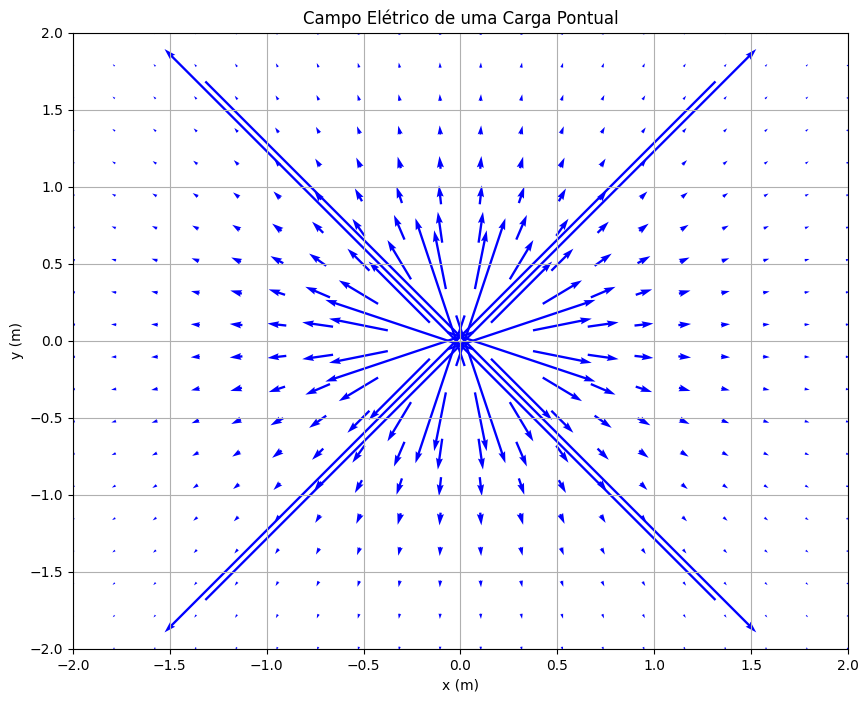

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def campo_eletrico(q, r, r0):
    """Calcula o campo elétrico gerado por uma carga pontual."""
    k = 8.99e9  # Constante de Coulomb (N m²/C²)
    r_vec = r - r0  # Vetor da carga até o ponto r
    mod_r = np.linalg.norm(r_vec)  # Módulo do vetor
    E = k * q / (mod_r**2) * (r_vec / mod_r)  # Campo elétrico
    return E

def fluxo_eletrico(q, r0, A):
    """Calcula o fluxo elétrico através da superfície A."""
    E = campo_eletrico(q, A.mean(axis=0), r0)  # Calcula E no centro da superfície
    dS = np.cross(A[1] - A[0], A[2] - A[0])  # Vetor área da superfície
    dS_norm = dS / np.linalg.norm(dS)  # Normaliza o vetor área
    fluxo = np.dot(E, dS_norm) * np.linalg.norm(dS)  # Calcula o fluxo
    return fluxo

# Definições da carga e posição
q = 1e-9  # Carga pontual (Coulombs)
r0 = np.array([0, 0, 0])  # Posição da carga (na origem)

# Define os vértices de uma superfície quadrada no plano z=1 (exemplo)
lado = 1.0  # Comprimento do lado do quadrado
A = np.array([
    [-lado/2, -lado/2, 1],  # Ponto inferior esquerdo
    [ lado/2, -lado/2, 1],  # Ponto inferior direito
    [ lado/2,  lado/2, 1],  # Ponto superior direito
    [-lado/2,  lado/2, 1]   # Ponto superior esquerdo
])

# Calcula o fluxo elétrico através da superfície
fluxo = fluxo_eletrico(q, r0, A)
print(f'Fluxo elétrico através da superfície: {fluxo:.2e} Nm²/C')

# Visualização do campo elétrico
x = np.linspace(-2, 2, 20)
y = np.linspace(-2, 2, 20)
X, Y = np.meshgrid(x, y)
Z = np.array([campo_eletrico(q, np.array([x_, y_, 0]), r0) for x_, y_ in zip(np.ravel(X), np.ravel(Y))])
E_field = Z.reshape(X.shape + (3,))

# Plotando o campo elétrico
plt.figure(figsize=(10, 8))
plt.quiver(X, Y, E_field[..., 0], E_field[..., 1], color='b', pivot='middle')
plt.quiver(A[:, 0], A[:, 1], 0, 0, scale=0, angles='xy', color='r')  # Superfície
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title('Campo Elétrico de uma Carga Pontual')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.show()
